### Emotion Analysis

In [1]:
!pip install emoji
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')
!pip install tf-keras
!pip install keras
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


#### Import Libraries

In [2]:
import pandas as pd
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk import pos_tag
from gensim.models import Word2Vec
from wordcloud import WordCloud
import gensim
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential  # Keep this for Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input  # Input here
# Removed: from sklearn.model_selection import train_test_split (already imported)
# Removed: from sklearn.metrics import classification_report (already imported)
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# Removed: import tensorflow as tf (not needed explicitly for keras with tf 2.x)
# Removed: from keras import layers, models (redundant and may cause issues)

2025-01-01 12:47:44.280265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/apple2015/Documents/MSc/SchoolStuff/NLP/Personal/Job Description Skill Analyzer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load and Explore Data

In [3]:
def load_data(file_path):
    """Load the dataset from a file."""
    return pd.read_csv(file_path)

In [4]:
def explore_data(df, text_column='text'):
    """
    Perform an extensive exploration of the dataset to check data cleanliness.

    Parameters:
    - df: Pandas DataFrame
    - text_column: Name of the column containing text data

    Returns:
    - Summary of findings
    """
    print("\n--- Basic Information ---")
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    print(f"Duplicate Rows: {df.duplicated().sum()}")

    print("\n--- Class Distribution ---")
    if 'label' in df.columns:
        print(df['label'].value_counts())
    else:
        print("No 'label' column found!")

    print("\n--- Text Analysis ---")
    # Check for empty or blank text
    empty_texts = df[text_column].isnull().sum() + df[text_column].str.strip().eq('').sum()
    print(f"Empty or Blank Texts: {empty_texts}")

    # Check for punctuation
    punctuations = df[text_column].apply(lambda x: len(re.findall(r'[^\w\s]', str(x))))
    print(f"Average Punctuation Count per Entry: {punctuations.mean():.2f}")

    # Check for emojis
    emojis = df[text_column].apply(lambda x: len(emoji.emoji_list(str(x))))
    print(f"Average Emoji Count per Entry: {emojis.mean():.2f}")

    # Check for stop words
    stop_words = set(stopwords.words('english'))
    stop_word_counts = df[text_column].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop_words]))
    print(f"Average Stop Words per Entry: {stop_word_counts.mean():.2f}")

    # Check for special characters (non-alphanumeric)
    special_chars = df[text_column].apply(lambda x: len(re.findall(r'[^\w\s]', str(x))))
    print(f"Average Special Characters per Entry: {special_chars.mean():.2f}")

    print("\n--- Recommendations ---")
    recommendations = []
    if empty_texts > 0:
        recommendations.append(f"Remove or handle {empty_texts} empty or blank entries.")
    if df.duplicated().sum() > 0:
        recommendations.append("Remove duplicate rows.")
    if emojis.mean() > 0:
        recommendations.append("Consider handling emojis (e.g., replace with words or remove).")
    if punctuations.mean() > 0:
        recommendations.append("Remove or handle punctuation marks appropriately.")
    if special_chars.mean() > 0:
        recommendations.append("Clean special characters from text.")

    if recommendations:
        print("\n".join(recommendations))
    else:
        print("The dataset appears clean!")

In [5]:
#Drop empty rows from our data
def drop_empty_rows(df):
    """Drop rows with empty text values."""
    return df.dropna(subset=['text']).reset_index(drop=True)

#### Preprocess Text

In [6]:
def remove_emojis(text):
    """Remove emojis from text."""
    return emoji.replace_emoji(text, replace="")

def remove_punctuation_and_symbols(text):
    """Remove punctuation, numbers, and special characters."""
    return re.sub(r'[^a-zA-Z\s]', '', text)

def preprocess_text(text):
    """Clean and preprocess text."""
    text = remove_emojis(text)
    text = remove_punctuation_and_symbols(text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

def apply_preprocessing(df):
    """Apply preprocessing to the text column."""
    df['text'] = df['text'].apply(preprocess_text)
    return df


#### Feature Engineering

In [7]:
def create_features_Tfidf(corpus):
    """Convert text into numerical representations."""
    vectorizer = TfidfVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

def create_features_CountVectorizer(corpus):
    """Convert text into numerical representations."""
    vectorizer = CountVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

def create_features_HashingVectorizer(corpus):
    """Convert text into numerical representations using HashingVectorizer."""
    vectorizer = HashingVectorizer(n_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

"""
def create_features_Word2Vec(corpus):
    Convert text into numerical representations using Word2Vec.
    tokenized_corpus = [doc.split() for doc in corpus]
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    features = np.array([np.mean([model.wv[word] for word in doc if word in model.wv] or [np.zeros(100)], axis=0) for doc in tokenized_corpus])
    return features, model
"""
# Create features using Word2Vec
def create_features_Word2Vec(corpus):
    """Convert text into numerical representations using Word2Vec."""
    tokenized_corpus = [doc.split() for doc in corpus]
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    # Calculate feature vectors as the mean of word vectors for each document
    features = np.array([
        np.mean([
            model.wv[word] for word in doc if word in model.wv
        ] or [np.zeros(100)], axis=0) for doc in tokenized_corpus
    ])
    return features, model

### Exploratory data analysis(EDA)

#### Model Training

##### Logistic Regression

In [8]:
def train_logistic_regression(X, y):
    """Train and evaluate a Logistic Regression model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    print("\n--- Logistic Regression Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model

##### Random Forest

In [9]:
def train_random_forest(X, y):
    """Train and evaluate a Random Forest Classifier."""
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    print("\n--- Random Forest Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model

##### Support Vector Machine

In [10]:
def train_svm(X, y):
    """Train and evaluate a Support Vector Machine (SVM)."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    print("\n--- SVM Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model


#### Evaluate Model

In [11]:
#Evaluation Function

def evaluate_model(model, X_test, y_test):
    """Evaluate the performance of a trained model."""
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

#### Predict

In [12]:
def predict_emotion(model, text, vectorizer):
    """Predict the emotion of a single input text."""
    processed_text = preprocess_text(text)
    features = vectorizer.transform([processed_text])
    return model.predict(features)


In [13]:
sampled_data_df = load_data('sampled_data.csv')
explore_data(sampled_data_df, text_column='text')  # Adjust 'text' if your column name differs



--- Basic Information ---
Dataset Shape: (100000, 2)
Columns: ['text', 'label']
Missing Values:
text     0
label    0
dtype: int64
Duplicate Rows: 0

--- Class Distribution ---
label
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64

--- Text Analysis ---
Empty or Blank Texts: 0
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 9.99
Average Special Characters per Entry: 0.00

--- Recommendations ---
The dataset appears clean!


In [14]:
emotions_df = load_data('data/emotions.csv')
explore_data(emotions_df, text_column='text')  # Adjust 'text' if your column name differs



--- Basic Information ---
Dataset Shape: (416809, 2)
Columns: ['text', 'label']
Missing Values:
text     0
label    0
dtype: int64
Duplicate Rows: 686

--- Class Distribution ---
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

--- Text Analysis ---
Empty or Blank Texts: 0
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 9.85
Average Special Characters per Entry: 0.00

--- Recommendations ---
Remove duplicate rows.


#### Class Distribution (Imbalance Visualization)

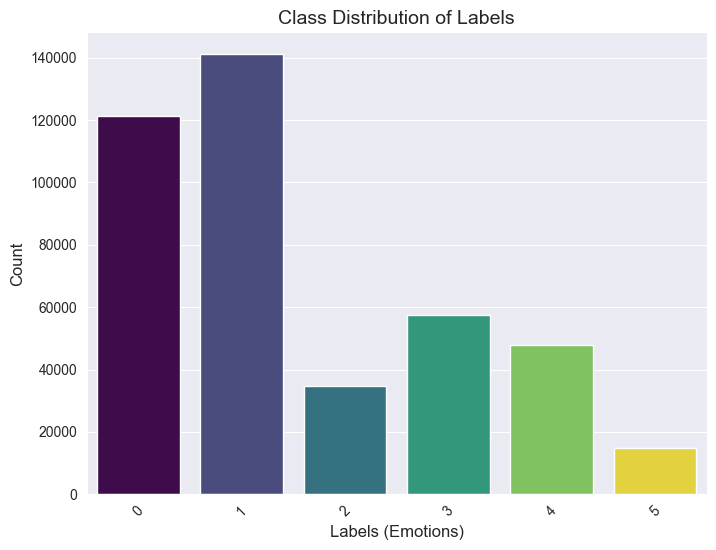

In [15]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=emotions_df, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

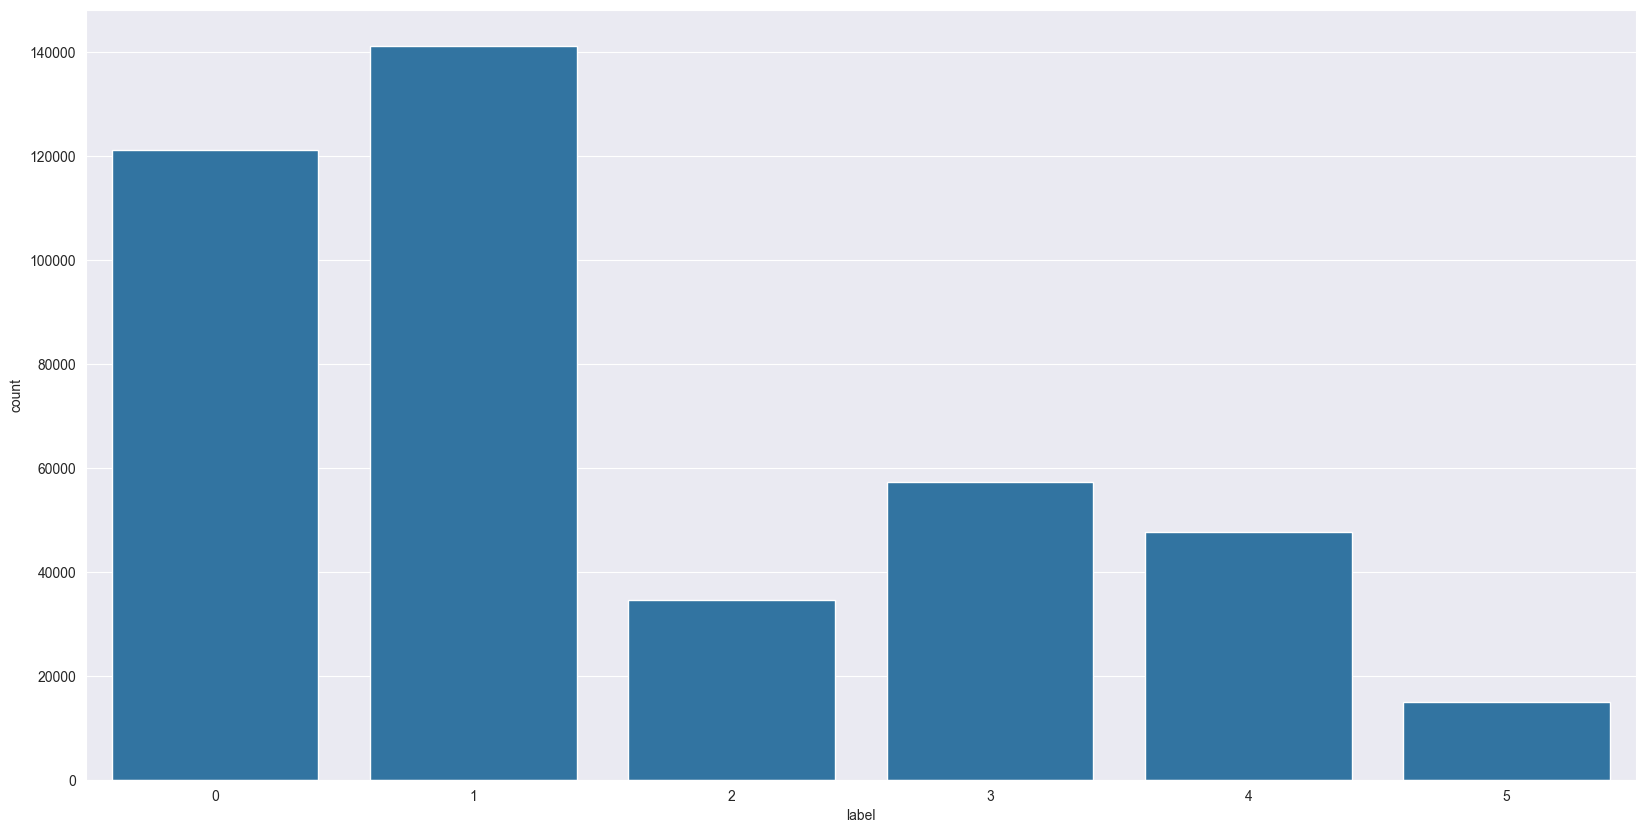

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(data=emotions_df,x='label')
plt.show()

In [19]:
emotions_df = apply_preprocessing(emotions_df)

In [20]:
sampled_data_df = apply_preprocessing(sampled_data_df)

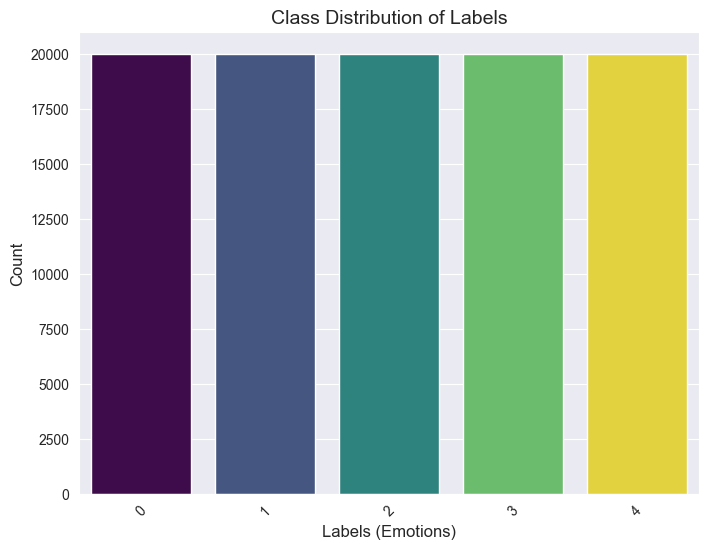

In [21]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=sampled_data_df, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

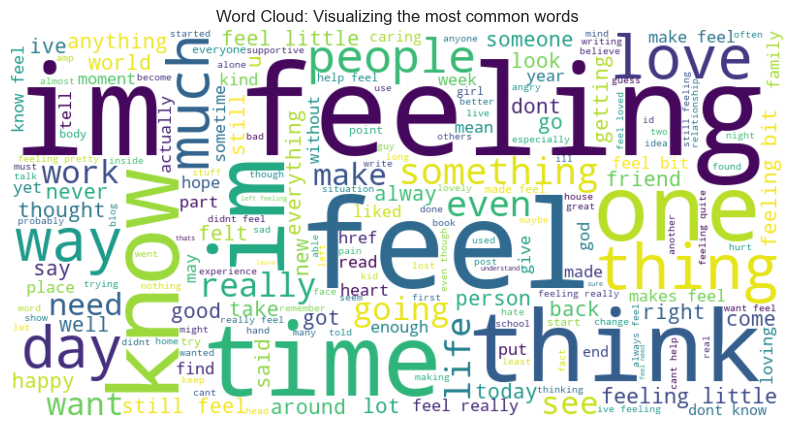

In [22]:
emotions_string = ' '.join(emotions_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotions_string)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Visualizing the most common words")
plt.show()

In [23]:
X, vectorizer = create_features_Tfidf(sampled_data_df['text'])  # 'text' is the name of your text column
y = sampled_data_df['label']  # Assuming the label column is named 'label'

In [24]:
logistic_model = train_logistic_regression(X, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4018
           1       0.94      0.92      0.93      4015
           2       0.93      0.97      0.95      4002
           3       0.94      0.94      0.94      3987
           4       0.94      0.96      0.95      3978

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [25]:
# Define the label to emotion mapping
label_to_emotion = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear'
}


# text_to_predict = "I am so happy today!"
text_to_predict = "it doesn't necessarily convey sadness or disappointment."

# Use the trained Logistic Regression model
predicted_emotion_logistic = predict_emotion(logistic_model, text_to_predict, vectorizer)
print(f"Predicted emotion (Logistic Regression): {predicted_emotion_logistic}")


Predicted emotion (Logistic Regression): [3]


In [26]:

print("\n--- Logistic Regression Evaluation ---")
evaluate_model(logistic_model, X, y)




--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     20000
           1       0.96      0.93      0.95     20000
           2       0.94      0.98      0.96     20000
           3       0.96      0.96      0.96     20000
           4       0.95      0.97      0.96     20000

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000



In [27]:
random_forest_model = train_random_forest(X, y)


--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4018
           1       0.97      0.89      0.93      4015
           2       0.91      0.99      0.95      4002
           3       0.93      0.94      0.94      3987
           4       0.93      0.97      0.95      3978

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [28]:
svm_model = train_svm(X, y)


--- SVM Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4018
           1       0.96      0.91      0.93      4015
           2       0.91      0.98      0.95      4002
           3       0.95      0.93      0.94      3987
           4       0.94      0.97      0.95      3978

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [29]:
# Generate Word2Vec features
X_word2vec, word2vec_model = create_features_Word2Vec(sampled_data_df['text'])# 'text' is the name of your text column
y = sampled_data_df['label'].values  # Assuming 'label' is the target column

In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)


In [31]:
# Reshape the data for LSTM: (samples, timesteps, features)
# Each document is treated as a sequence of timesteps with 100 features (Word2Vec vector size)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # Treat each document as 1 timestep
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [32]:
print(np.mean(X_word2vec, axis=0))
print("---------------------------- ----------------------------")
print(np.std(X_word2vec, axis=0))

[ 4.56996390e-02  5.48440345e-01  3.09809905e-01  4.77771924e-01
  1.19105648e-01 -8.98859355e-01  9.97899556e-02  9.90298449e-01
 -4.10254050e-01 -3.07880930e-01 -2.46491443e-01 -7.88737644e-01
  9.14030482e-02  2.83321164e-01  1.10977130e-01  4.46923584e-02
  6.44634395e-01 -4.78260746e-02  3.13952036e-02 -8.32691805e-01
  9.74291997e-01  3.55315717e-01  7.18280311e-02 -3.49692187e-01
 -1.13328295e-01  1.94820045e-02 -4.89483313e-01  3.37031515e-02
 -1.65872875e-01  4.38661884e-01  2.40936547e-01  2.14243391e-02
  2.03093190e-02 -8.03215903e-01 -2.68225227e-02  4.71072202e-01
  4.75854676e-01 -6.83537837e-02 -6.81168782e-02 -3.88649040e-01
 -2.54000738e-01 -3.34973975e-01 -6.30770659e-02 -2.07184031e-01
  6.33093068e-01 -1.34199973e-01 -4.06568284e-01  1.69753162e-01
  5.68259487e-02  1.05285985e-01 -3.90433729e-01 -2.36047857e-01
 -1.85855589e-01  1.33916956e-01 -3.08482621e-01  3.74405733e-01
  5.41095890e-01  1.07572175e-04 -4.14031743e-01  3.38242094e-01
  1.81636463e-01  3.35712

In [42]:
# Define the LSTM model
n_classes = len(np.unique(y))
# Adjust the Dense layer for multi-class classification

lstm_model = Sequential()
lstm_model.add(Input(shape=(1, X_train.shape[1])))  # Input shape (timesteps, features)
#lstm_model.add(LSTM(50, activation='relu'))  # LSTM layer with 50 units(Accuracy: 54.48%, Loss: 1.1183)
#lstm_model.add(LSTM(100, activation='relu'))  # LSTM layer with 50 units(Accuracy: 55.41%, Loss: 1.0993)
lstm_model.add(LSTM(100, activation='tanh', return_sequences=True, dropout=0.2))  # LSTM layer with 50 units
#lstm_model.add(LSTM(50, activation='tanh')  # Second LSTM layer (accuracy: 57.32% - loss: 1.0427)
#lstm_model.add(LSTM(50, activation='tanh', dropout=0.2))  # Second LSTM layer (accuracy: 0.4336 - loss: 1.3201)
lstm_model.add(LSTM(50, activation='tanh', dropout=0.1))  # Second LSTM layer (accuracy: 0.4336 - loss: 1.3201)
lstm_model.add(Dense(n_classes, activation='softmax'))  # Output layer for multi-class classification
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 1, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,855 (433.03 KB)

 Trainable params: 110,855 (433.03 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Train the model
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.3463 - loss: 1.4616
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.4016 - loss: 1.3796
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.4072 - loss: 1.3723
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.4127 - loss: 1.3552
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.4231 - loss: 1.3478
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.4257 - loss: 1.3370
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4339 - loss: 1.3307
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4343 - loss: 1.3228
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4310 - loss: 1.3213
Epoch 10/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4336 - loss: 1.3201


In [35]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5474 - loss: 1.1183
Test Loss: 1.118362545967102
Test Accuracy: 0.5482500195503235


In [42]:
# Build LSTM model
def build_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [44]:
lstm_model = build_lstm_model(vocab_size=20000, embedding_dim=100, input_length=100)
lstm_model.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=5, batch_size=32)




/Users/apple2015/Documents/MSc/SchoolStuff/NLP/Personal/Job Description Skill Analyzer/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5


ValueError: Input 0 of layer "lstm_5" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (32, 100, 1, 100)

In [ ]:
# Evaluate LSTM
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_pred_classes = np.argmax(lstm_predictions, axis=1)
print("\n--- LSTM Evaluation ---")
print(classification_report(y_test_lstm, lstm_pred_classes))


In [ ]:
# Prepare data for BERT
def prepare_data_for_bert(df, text_column='text', label_column='label'):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    inputs = tokenizer(list(df[text_column]), padding=True, truncation=True, return_tensors='pt', max_length=128)
    labels = torch.tensor(df[label_column].values)
    return inputs, labels

In [ ]:
bert_inputs, bert_labels = prepare_data_for_bert(df)


In [ ]:
# Train/Test split for BERT
train_size = int(0.8 * len(bert_labels))
train_inputs = {k: v[:train_size] for k, v in bert_inputs.items()}
train_labels = bert_labels[:train_size]
test_inputs = {k: v[train_size:] for k, v in bert_inputs.items()}
test_labels = bert_labels[train_size:]


In [ ]:
# Fine-tune BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)

In [ ]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=list(zip(train_inputs['input_ids'], train_labels)),
    eval_dataset=list(zip(test_inputs['input_ids'], test_labels))
)

In [ ]:
trainer.train()

In [ ]:
# Evaluate BERT
bert_outputs = bert_model(**test_inputs)
bert_pred_classes = torch.argmax(bert_outputs.logits, axis=1)
print("\n--- BERT Evaluation ---")
print(classification_report(test_labels.numpy(), bert_pred_classes.numpy()))

In [ ]:
sns.histplot(df['numerical_column'])


In [ ]:
sns.countplot(x='categorical_column', data=df)


In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


In [ ]:
plt.show()


In [ ]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'])


In [ ]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
sns.countplot(x='label', data=df)
